In [104]:
import os
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime


from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder,OrdinalEncoder

# Import regression models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
import catboost as cb
import xgboost as xgb
import lightgbm as lgb


import warnings
warnings.filterwarnings('ignore')

In [105]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
ss = pd.read_csv('data/sample_submission.csv')

In [106]:
train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [107]:
test.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


In [108]:
year = datetime.datetime.now().year
train['age'] = train['model_year'].apply(lambda x: year-x)
train

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,age
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,18
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,23
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,23
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,8
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,188528,Cadillac,Escalade ESV Platinum,2017,49000,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Beige,None reported,Yes,27500,8
188529,188529,Mercedes-Benz,AMG C 43 AMG C 43 4MATIC,2018,28600,Gasoline,385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Black,At least 1 accident or damage reported,Yes,30000,7
188530,188530,Mercedes-Benz,AMG GLC 63 Base 4MATIC,2021,13650,Gasoline,469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,White,Black,None reported,Yes,86900,4
188531,188531,Audi,S5 3.0T Prestige,2022,13895,Gasoline,3.0L,1-Speed Automatic,Daytona Gray Pearl Effect,Black,None reported,NaN,84900,3


<Axes: >

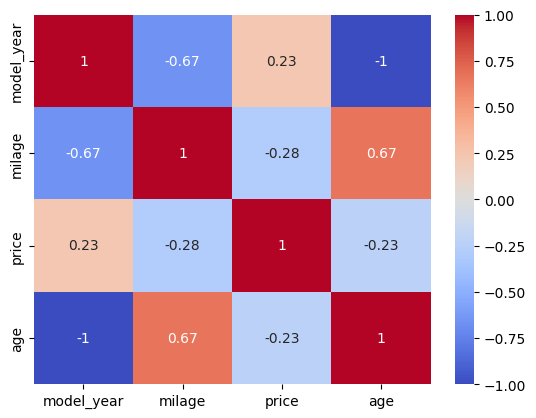

In [109]:
corr_matrix = train[train.select_dtypes(include=['number']).drop(columns=['id']).columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

In [110]:
train.describe()

,id,model_year,milage,price,age
count,188533.000000,188533.000000,188533.000000,1.885330e+05,188533.000000
mean,94266.000000,2015.829998,65705.295174,4.387802e+04,9.170002
std,54424.933488,5.660967,49798.158076,7.881952e+04,5.660967
min,0.000000,1974.000000,100.000000,2.000000e+03,1.000000
25%,47133.000000,2013.000000,24115.000000,1.700000e+04,5.000000
50%,94266.000000,2017.000000,57785.000000,3.082500e+04,8.000000
75%,141399.000000,2020.000000,95400.000000,4.990000e+04,12.000000
max,188532.000000,2024.000000,405000.000000,2.954083e+06,51.000000


In [111]:
train['accident'].value_counts()

accident
None reported                             144514
At least 1 accident or damage reported     41567
Name: count, dtype: int64

In [112]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
 13  age           188533 non-null  int64 
dtypes: int64(5), object(9)
memory usage: 20.1+ MB


In [113]:
train.describe()

,id,model_year,milage,price,age
count,188533.000000,188533.000000,188533.000000,1.885330e+05,188533.000000
mean,94266.000000,2015.829998,65705.295174,4.387802e+04,9.170002
std,54424.933488,5.660967,49798.158076,7.881952e+04,5.660967
min,0.000000,1974.000000,100.000000,2.000000e+03,1.000000
25%,47133.000000,2013.000000,24115.000000,1.700000e+04,5.000000
50%,94266.000000,2017.000000,57785.000000,3.082500e+04,8.000000
75%,141399.000000,2020.000000,95400.000000,4.990000e+04,12.000000
max,188532.000000,2024.000000,405000.000000,2.954083e+06,51.000000


In [114]:
null_train = train.isnull().sum()
null_test = test.isnull().sum()
null_df = pd.concat([null_train, null_test], axis=1, keys=['train', 'test'])
null_df['% missing train'] = null_df['train']/len(train)
null_df['% missing test'] = null_df['test']/len(test)
null_df

,train,test,% missing train,% missing test
id,0,0.0,0.000000,0.000000
brand,0,0.0,0.000000,0.000000
model,0,0.0,0.000000,0.000000
model_year,0,0.0,0.000000,0.000000
milage,0,0.0,0.000000,0.000000
fuel_type,5083,3383.0,0.026961,0.026915
engine,0,0.0,0.000000,0.000000
transmission,0,0.0,0.000000,0.000000
ext_col,0,0.0,0.000000,0.000000
int_col,0,0.0,0.000000,0.000000


In [115]:
print("duplicate train: ", train.duplicated().sum())
print("duplicate test: ", test.duplicated().sum())

duplicate train:  0
duplicate test:  0


In [116]:
train.fuel_type.value_counts()


fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15
Name: count, dtype: int64

In [117]:
test.fuel_type.value_counts()

fuel_type
Gasoline          110533
Hybrid              4676
E85 Flex Fuel       3523
Diesel              2686
–                    538
Plug-In Hybrid       337
not supported         14
Name: count, dtype: int64

In [118]:
print(train['engine'].iloc[0])

172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel


In [119]:
fuel_missing_df = train[train['fuel_type'].isnull()]
fuel_missing_df.brand.value_counts()
# Tesla is electric 

brand
Tesla            3361
Rivian            497
Ford              427
Porsche           190
Audi              121
Mercedes-Benz      61
BMW                60
Nissan             56
Kia                54
Lucid              52
Chevrolet          43
Hyundai            29
Volkswagen         28
Toyota             16
Karma              12
Volvo               9
Acura               8
Cadillac            7
Dodge               7
GMC                 5
Polestar            5
Jeep                4
Land                4
MINI                3
Jaguar              2
RAM                 2
Bentley             2
Pontiac             2
Genesis             2
INFINITI            2
FIAT                2
smart               1
Maserati            1
Ferrari             1
McLaren             1
Chrysler            1
Lotus               1
Mitsubishi          1
Lamborghini         1
Lincoln             1
Alfa                1
Name: count, dtype: int64

In [120]:
train.clean_title.value_counts()

clean_title
Yes    167114
Name: count, dtype: int64

In [121]:
clean_title_missing_df = train[train['clean_title'].isnull()]

In [122]:
def feature_engineering(df):

    year = datetime.datetime.now().year
    df['age'] = df['model_year'].apply(lambda x: year-x)

    df['risk_dead_engine'] = df['milage'].map(lambda x: 1 if x>300000 else 0)

    def overworked(row):
        if row['milage']>50000 and row['age']<1:
            return 1
        elif row['milage']>100000 and row['age']<2:
            return 1
        elif row['milage']>300000 and row['age']<10:
            return 1
        return 0

    def fresh_engine(row):
        if row['milage']<10000:
            return 1
        if row['milage']<30000 and row['age']>=2:
            return 1
        return 0
    df['overworked'] = df.apply(overworked, axis=1)
    df['fresh_engine'] = df.apply(fresh_engine, axis=1)


    df['Cylinder'] = df['engine'].str.extract(r'(\d+)\s+Cylinder', expand=False).fillna(-1).astype(int)

    df['engine_Litr'] = df['engine'].str.extract(r'(\d+\.\d+)\s+L', expand=False).fillna(-1).astype(float)

    return df

In [123]:
test_ids = test['id']
def preprocess_data(train, test):

    # drop duplicates
    train = train.drop_duplicates()

    # concat train and test
    test['price'] = -1
    df = pd.concat([train, test], axis=0, ignore_index=True)

    # missing values :

    ## fuel_type
    mask = df['fuel_type'].isnull()
    df.loc[mask, 'fuel_type'] = df.loc[mask, 'engine'].map(lambda x: 'Plug-In Hybrid' if 'Plug-In' in x else 'Hybrid' if 'Hybrid' in x else 'Gasoline' if 'Gasoline' in x else 'E85 Flex Fuel' if 'Flex Fuel' in x else  'Diesel' if 'Diesel|GDI' in x else 'Other')
    ## clean_title
    mask = df['clean_title'].isnull()
    df.loc[mask, 'clean_title'] = 'No'
    ## accident 
    mask = df['accident'].isnull()
    df.loc[mask, 'accident'] = 'None reported'

    # feature engineering
    df = feature_engineering(df)


    # drop null values
    # df.dropna(inplace=True)

    # drop cols
    cols = ['id']
    df.drop(cols, axis=1, inplace=True)







    # Encode categorical features
    ## feature to one hot encoding
    features_to_1hotEncode = ['accident']
    df = pd.get_dummies(df, columns=features_to_1hotEncode)
    
    train = df[df['price']!=-1]
    test = df[df['price']==-1]

    ## feature for label encoding
    cols_to_LabelEncode = train.select_dtypes(include=['object']).columns
    le = LabelEncoder()

    for col in tqdm(cols_to_LabelEncode,desc='Encoding categorical features'):
        if col in train.columns and col in test.columns:
            classes_ = train[col].unique()
            train[col] = le.fit_transform(train[col])
            test[col] = test[col].map(lambda x: le.transform([x])[0] if x in classes_ else -1)

    return train, test

In [124]:
train, test = preprocess_data(train, test)

Encoding categorical features: 100%|██████████| 8/8 [03:14<00:00, 24.25s/it]


In [125]:
train.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,clean_title,price,age,risk_dead_engine,overworked,fresh_engine,Cylinder,engine_Litr,accident_At least 1 accident or damage reported,accident_None reported
0,31,495,2007,213000,2,116,38,312,71,1,4200,18,0,0,0,4,-1.0,False,True
1,28,930,2002,143250,2,366,38,263,10,1,4999,23,0,0,0,8,-1.0,True,False
2,9,1575,2002,136731,1,640,38,38,71,1,13900,23,0,0,0,8,-1.0,False,True
3,16,758,2017,19500,2,863,49,29,14,1,45000,8,0,0,1,8,-1.0,False,True
4,36,1077,2021,7388,2,259,23,29,10,1,97500,4,0,0,1,4,-1.0,False,True


In [126]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('price', axis=1), train['price'], test_size=0.2, random_state=42)

In [127]:
cat_model = cb.CatBoostRegressor(loss_function='RMSE', verbose=100)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
lgb_model = lgb.LGBMRegressor(objective='regression', metric='rmse', random_state=42)
rf_model = RandomForestRegressor(random_state=42)

models = [cat_model, xgb_model, lgb_model, rf_model]

In [128]:
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    print(f"{model.__class__.__name__} RMSE: {rmse}")

Learning rate set to 0.090444
0:	learn: 79061.6491866	total: 7.91ms	remaining: 7.9s
100:	learn: 73113.7468865	total: 600ms	remaining: 5.34s
200:	learn: 71747.6484133	total: 1.2s	remaining: 4.75s
300:	learn: 70490.3165702	total: 1.81s	remaining: 4.2s
400:	learn: 69704.8242543	total: 2.35s	remaining: 3.52s
500:	learn: 68795.2749602	total: 2.9s	remaining: 2.88s
600:	learn: 67997.7687162	total: 3.43s	remaining: 2.28s
700:	learn: 67276.9662175	total: 4.01s	remaining: 1.71s
800:	learn: 66561.0776841	total: 4.54s	remaining: 1.13s
900:	learn: 65649.8114973	total: 5.09s	remaining: 559ms
999:	learn: 64897.0046599	total: 5.62s	remaining: 0us
CatBoostRegressor RMSE: 68532.0601364936
XGBRegressor RMSE: 69696.59375
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force

In [21]:
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    print(f"{model.__class__.__name__} RMSE: {rmse}")

Learning rate set to 0.090444
0:	learn: 79070.3523631	total: 160ms	remaining: 2m 39s
100:	learn: 73112.9942375	total: 707ms	remaining: 6.29s
200:	learn: 71816.6909137	total: 1.24s	remaining: 4.93s
300:	learn: 70588.7551442	total: 1.79s	remaining: 4.16s
400:	learn: 69558.1749456	total: 2.33s	remaining: 3.48s
500:	learn: 68686.5100707	total: 2.86s	remaining: 2.85s
600:	learn: 67671.6678130	total: 3.39s	remaining: 2.25s
700:	learn: 66738.0891913	total: 3.92s	remaining: 1.67s
800:	learn: 65836.0191708	total: 4.45s	remaining: 1.11s
900:	learn: 65046.7434664	total: 4.98s	remaining: 547ms
999:	learn: 64334.1619425	total: 5.51s	remaining: 0us
CatBoostRegressor RMSE: 68660.19757383986
XGBRegressor RMSE: 70942.578125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1257
[LightGBM] [Info] Numbe

In [129]:
folder_name = 'submission'
os.makedirs(folder_name, exist_ok=True)

# Make predictions on the test set
test_predictions = []

# Remove 'price' column from test data if it exists
test_features = test.drop('price', axis=1) if 'price' in test.columns else test

for model in models:
    model.fit(train.drop('price', axis=1), train['price'])
    pred = model.predict(test_features)
    test_predictions.append(pred)
    
    # Create individual submission file for each model
    model_submission = pd.DataFrame({
        'id': test_ids,
        'price': pred
    })
    
    model_name = model.__class__.__name__
    model_submission.to_csv(f'{folder_name}/submission_{model_name}.csv', index=False)
    print(f"{model_name} submission file created successfully!")

# Create ensemble prediction (average of all models)
ensemble_pred = np.mean(test_predictions, axis=0)

# Create ensemble submission file
ensemble_submission = pd.DataFrame({
    'id': test_ids,
    'price': ensemble_pred
})

ensemble_submission.to_csv(f'{folder_name}/submission_ensemble.csv', index=False)
print("Ensemble submission file created successfully!")
print(ensemble_submission.head())


Learning rate set to 0.093689
0:	learn: 78012.3521724	total: 9.42ms	remaining: 9.41s
100:	learn: 71918.4417816	total: 655ms	remaining: 5.83s
200:	learn: 70744.1462564	total: 1.28s	remaining: 5.11s
300:	learn: 69750.4611897	total: 1.9s	remaining: 4.41s
400:	learn: 69013.9746976	total: 2.52s	remaining: 3.77s
500:	learn: 68251.9312432	total: 3.15s	remaining: 3.13s
600:	learn: 67387.5936109	total: 3.76s	remaining: 2.5s
700:	learn: 66613.3623660	total: 4.38s	remaining: 1.87s
800:	learn: 65727.2678610	total: 5s	remaining: 1.24s
900:	learn: 64998.1087107	total: 5.64s	remaining: 619ms
999:	learn: 64378.4246427	total: 6.24s	remaining: 0us
CatBoostRegressor submission file created successfully!
XGBRegressor submission file created successfully!
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory

In [53]:
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    print(f"{model.__class__.__name__} RMSE: {rmse}")

Learning rate set to 0.088355
0:	learn: 74144.6322170	total: 7.22ms	remaining: 7.22s
100:	learn: 68391.8470269	total: 498ms	remaining: 4.43s
200:	learn: 67015.8891225	total: 1s	remaining: 3.99s
300:	learn: 65680.1864484	total: 1.46s	remaining: 3.39s
400:	learn: 64296.3232299	total: 1.92s	remaining: 2.86s
500:	learn: 62954.7587072	total: 2.37s	remaining: 2.36s
600:	learn: 61757.6289191	total: 2.83s	remaining: 1.88s
700:	learn: 60630.3259597	total: 3.29s	remaining: 1.4s
800:	learn: 59592.7573214	total: 3.74s	remaining: 930ms
900:	learn: 58575.3858153	total: 4.2s	remaining: 462ms
999:	learn: 57638.0098782	total: 4.65s	remaining: 0us
CatBoostRegressor RMSE: 77710.27302694258
XGBRegressor RMSE: 79647.625
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 130088, number of used features: 9
[L

In [15]:
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    print(f"{model.__class__.__name__} RMSE: {rmse}")

Learning rate set to 0.088355
0:	learn: 74127.4223746	total: 183ms	remaining: 3m 3s
100:	learn: 68308.1055719	total: 681ms	remaining: 6.07s
200:	learn: 67086.2334295	total: 1.17s	remaining: 4.66s
300:	learn: 65537.1516637	total: 1.63s	remaining: 3.79s
400:	learn: 63946.8402049	total: 2.09s	remaining: 3.12s
500:	learn: 62668.9930880	total: 2.55s	remaining: 2.54s
600:	learn: 61539.4378007	total: 3.02s	remaining: 2s
700:	learn: 60455.2538220	total: 3.51s	remaining: 1.5s
800:	learn: 59500.3290693	total: 3.98s	remaining: 989ms
900:	learn: 58499.1023768	total: 4.44s	remaining: 488ms
999:	learn: 57649.8541998	total: 4.89s	remaining: 0us
CatBoostRegressor RMSE: 77883.75427793869
XGBRegressor RMSE: 80178.5234375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1451
[LightGBM] [Info] Number of data points in the train set: 130088, number of used features: 